In [50]:
import numpy as np
import pandas as pd


df = pd.read_csv("../data/csv_data/stress_cluster_labels.csv")

X = np.stack([
    np.load(f"../data/embeddings/00_{i:05d}.npy") for i in df["id"]
])

y = df["label"].values

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [52]:
from sklearn.metrics import classification_report, accuracy_score

def evaluate_model(name, model, X_train, X_test, y_train, y_test, results):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    results[name] = acc


In [53]:
results = {}

In [54]:
from sklearn.linear_model import LogisticRegression

evaluate_model("Logistic Regression", LogisticRegression(
    max_iter=1000, solver='lbfgs'
), X_train, X_test, y_train, y_test, results)


=== Logistic Regression ===
Accuracy: 0.8772
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       810
           1       1.00      0.18      0.31       143

    accuracy                           0.88       953
   macro avg       0.94      0.59      0.62       953
weighted avg       0.89      0.88      0.84       953



In [55]:
from sklearn.ensemble import RandomForestClassifier

evaluate_model("Random Forest", RandomForestClassifier(
    n_estimators=100, random_state=42
), X_train, X_test, y_train, y_test, results)


=== Random Forest ===
Accuracy: 0.9433
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       810
           1       0.86      0.74      0.80       143

    accuracy                           0.94       953
   macro avg       0.91      0.86      0.88       953
weighted avg       0.94      0.94      0.94       953



In [56]:
from sklearn.svm import SVC

evaluate_model("SVM", SVC(kernel='rbf', C=1.0), X_train, X_test, y_train, y_test, results)


=== SVM ===
Accuracy: 0.9454
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       810
           1       0.84      0.79      0.81       143

    accuracy                           0.95       953
   macro avg       0.90      0.88      0.89       953
weighted avg       0.94      0.95      0.94       953



In [57]:
from catboost import CatBoostClassifier

evaluate_model("CatBoost", CatBoostClassifier(
    verbose=0, random_state=42
), X_train, X_test, y_train, y_test, results)


=== CatBoost ===
Accuracy: 0.9433
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       810
           1       0.85      0.76      0.80       143

    accuracy                           0.94       953
   macro avg       0.90      0.87      0.88       953
weighted avg       0.94      0.94      0.94       953



In [58]:
import xgboost as xgb

evaluate_model("XGBoost", xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=(len(y_train) / np.sum(y_train) - 1),
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
), X_train, X_test, y_train, y_test, results)


c:\Users\Win\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:52:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
Accuracy: 0.9255
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       810
           1       0.70      0.87      0.78       143

    accuracy                           0.93       953
   macro avg       0.84      0.90      0.87       953
weighted avg       0.94      0.93      0.93       953



In [59]:
import lightgbm as lgb


evaluate_model("LightGBM", lgb.LGBMClassifier(
    objective='binary',
    is_unbalance=True,
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
), X_train, X_test, y_train, y_test, results)


[LightGBM] [Info] Number of positive: 571, number of negative: 3237
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 3808, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149947 -> initscore=-1.735013
[LightGBM] [Info] Start training from score -1.735013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [78]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
}

search = RandomizedSearchCV(
    lgb.LGBMClassifier(objective='binary', is_unbalance=True),
    param_distributions=params,
    scoring='accuracy',
    cv=5,
    n_iter=10,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

evaluate_model("LGBM Tuned", search, X_train, X_test, y_train, y_test, results)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 571, number of negative: 3237
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 3808, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149947 -> initscore=-1.735013
[LightGBM] [Info] Start training from score -1.735013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [61]:
best_model_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=(len(y_train) / np.sum(y_train) - 1),
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
best_model_xgb.fit(X_train, y_train)


best_model_lgb = lgb.LGBMClassifier(
    objective='binary',
    is_unbalance=True,
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
best_model_lgb.fit(X_train, y_train)


from sklearn.ensemble import VotingClassifier

# Create Voting ensemble using best tuned LGBM and XGB models
voting_ensemble = VotingClassifier(estimators=[
    ('lgb', lgb.LGBMClassifier(**best_model_lgb.get_params())),
    ('xgb', xgb.XGBClassifier(**best_model_xgb.get_params()))
], voting='soft')

# Evaluate and log results
evaluate_model("Voting (LGB + XGB)", voting_ensemble, X_train, X_test, y_train, y_test, results)



c:\Users\Win\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:53:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 571, number of negative: 3237
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 3808, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149947 -> initscore=-1.735013
[LightGBM] [Info] Start training from score -1.735013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Win\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:53:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Voting (LGB + XGB) ===
Accuracy: 0.9265
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       810
           1       0.71      0.87      0.78       143

    accuracy                           0.93       953
   macro avg       0.84      0.90      0.87       953
weighted avg       0.94      0.93      0.93       953



In [62]:
# Base models (without tuning yet — use minimal params here to allow search)
lgb_model = lgb.LGBMClassifier(objective='binary', is_unbalance=True, random_state=42)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

ensemble = VotingClassifier(estimators=[
    ('lgb', lgb_model),
    ('xgb', xgb_model)
], voting='soft')

# Parameter grid — include base model parameters using __ syntax
param_grid = {
    'lgb__n_estimators': [100, 200],
    'lgb__learning_rate': [0.01, 0.05, 0.1],
    'lgb__max_depth': [3, 4, 5],

    'xgb__n_estimators': [100, 200],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [3, 4, 5],
}

# Run hyperparameter search
search = RandomizedSearchCV(
    ensemble,
    param_distributions=param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

# Best model from search
best_ensemble = search.best_estimator_

# Evaluate and log results
evaluate_model("Voting (LGB + XGB, tuned)", best_ensemble, X_train, X_test, y_train, y_test, results)

# Optional: show best hyperparameters
#print("Best Parameters:")
#print(search.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 571, number of negative: 3237
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 3808, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149947 -> initscore=-1.735013
[LightGBM] [Info] Start training from score -1.735013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

c:\Users\Win\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:54:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 571, number of negative: 3237
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 3808, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149947 -> initscore=-1.735013
[LightGBM] [Info] Start training from score -1.735013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Win\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:54:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Voting (LGB + XGB, tuned) ===
Accuracy: 0.9517
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       810
           1       0.84      0.84      0.84       143

    accuracy                           0.95       953
   macro avg       0.91      0.91      0.91       953
weighted avg       0.95      0.95      0.95       953



In [63]:
# Define base models
svm_clf = SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', random_state=42)
lgb_clf = lgb.LGBMClassifier(objective='binary', is_unbalance=True, random_state=42)

# Define soft voting ensemble
voting_clf = VotingClassifier(estimators=[
    ('svm', svm_clf),
    ('lgb', lgb_clf)
], voting='soft')

# Fit and evaluate using your evaluate_model() utility
evaluate_model("Voting (SVM + LGB)", voting_clf, X_train, X_test, y_train, y_test, results)

[LightGBM] [Info] Number of positive: 571, number of negative: 3237
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 3808, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149947 -> initscore=-1.735013
[LightGBM] [Info] Start training from score -1.735013

=== Voting (SVM + LGB) ===
Accuracy: 0.9475
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       810
           1       0.81      0.85      0.83       143

    accuracy                           0.95       953
   macro avg       0.89      0.91      0.90       953
weighted avg       0.95      0.95      0.95       953



In [64]:
from sklearn.ensemble import StackingClassifier

# Base learners
estimators = [
    ('svm', SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', random_state=42)),
    ('lgb', lgb.LGBMClassifier(objective='binary', is_unbalance=True, random_state=42))
]

# Meta learner
meta_learner = LogisticRegression()

# Stacking classifier
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=meta_learner, cv=5)

# Fit and evaluate using your utility
evaluate_model("Stacking (SVM + LGB)", stacking_clf, X_train, X_test, y_train, y_test, results)


[LightGBM] [Info] Number of positive: 571, number of negative: 3237
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 3808, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149947 -> initscore=-1.735013
[LightGBM] [Info] Start training from score -1.735013
[LightGBM] [Info] Number of positive: 457, number of negative: 2589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 3046, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.150033 -> initscore=-1.734344
[LightGBM] [Info] Start training from score -1.734344
[LightGBM] [Info

In [65]:

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Base models
svm = make_pipeline(StandardScaler(), SVC(probability=True, random_state=42))
lgbm = lgb.LGBMClassifier(objective='binary', is_unbalance=True, random_state=42)

# Stacking classifier
stack_model = StackingClassifier(
    estimators=[('svm', svm), ('lgbm', lgbm)],
    final_estimator=LogisticRegression(max_iter=1000),
    passthrough=False,
    cv=5,
    n_jobs=-1
)

# Parameter grid
param_grid = {
    'svm__svc__C': [0.1, 1, 10],
    'lgbm__n_estimators': [50, 100],
    'lgbm__max_depth': [3, 5],
    'final_estimator__C': [0.1, 1, 10]
}

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=stack_model,
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit search
random_search.fit(X_train, y_train)

# Final evaluation
best_model = random_search.best_estimator_
evaluate_model("Tuned Stacking (SVM + LGB)", best_model, X_train, X_test, y_train, y_test, results)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

=== Tuned Stacking (SVM + LGB) ===
Accuracy: 0.9517
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       810
           1       0.85      0.82      0.84       143

    accuracy                           0.95       953
   macro avg       0.91      0.90      0.90       953
weighted avg       0.95      0.95      0.95       953



In [68]:
# Base models
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

lgb_model = lgb.LGBMClassifier(
    objective='binary',
    is_unbalance=True,
    random_state=42
)

# Stacking classifier
stack_model = StackingClassifier(
    estimators=[('xgb', xgb_model), ('lgb', lgb_model)],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Hyperparameter grid
param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [3, 5, 7],
    'lgb__n_estimators': [100, 200],
    'lgb__learning_rate': [0.01, 0.05, 0.1],
    'lgb__max_depth': [3, 5, 7],
    'final_estimator__C': [0.1, 1, 10]
}

# RandomizedSearchCV for light tuning
random_search = RandomizedSearchCV(
    estimator=stack_model,
    param_distributions=param_grid,
    n_iter=15,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit search
random_search.fit(X_train, y_train)

# Get best model
best_model = random_search.best_estimator_

# Evaluate the tuned stacking model
evaluate_model("Tuned Stacking (XGB + LGB)", best_model, X_train, X_test, y_train, y_test, results)

Fitting 3 folds for each of 15 candidates, totalling 45 fits

=== Tuned Stacking (XGB + LGB) ===
Accuracy: 0.9475
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       810
           1       0.83      0.81      0.82       143

    accuracy                           0.95       953
   macro avg       0.90      0.89      0.90       953
weighted avg       0.95      0.95      0.95       953



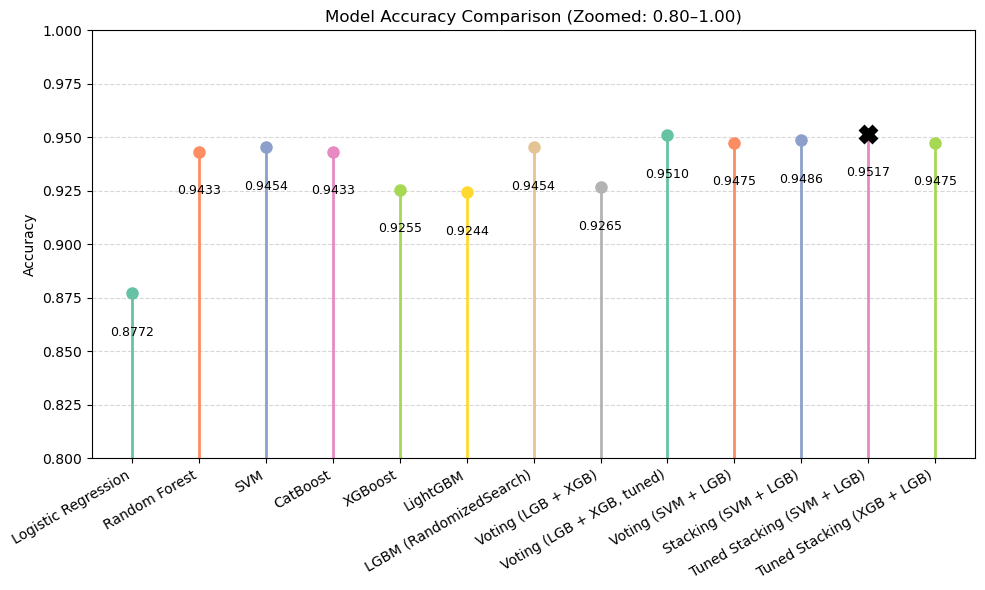

In [83]:
import matplotlib.pyplot as plt

# Sort results for better visualization
# results_sorted = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))

model_names = list(results.keys())
accuracies = list(results.values())
best_idx = accuracies.index(max(accuracies))

plt.figure(figsize=(10, 6))
colors = plt.cm.Set2.colors  # Softer distinct colors

# Plot thin vertical bars with circles at the top
for i, (model, acc) in enumerate(results.items()):
    color = colors[i % len(colors)]
    
    # Thin vertical bar
    plt.plot([i, i], [0.80, acc], color=color, linewidth=2)  # Start bar at 0.80
    
    # Dot at top of bar
    plt.plot(i, acc, 'o', color=color, markersize=8)

    # Accuracy text slightly below the dot
    plt.text(i, acc - 0.02, f"{acc:.4f}", ha='center', fontsize=9)

# Highlight best model with a black 'X' at the top
plt.plot(best_idx, accuracies[best_idx], 'X', color='black', markersize=12, markeredgewidth=2)

# Styling
plt.xticks(ticks=range(len(model_names)), labels=model_names, rotation=30, ha='right')
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison (Zoomed: 0.80–1.00)")
plt.ylim(0.80, 1.00)  # Zoomed-in range for better clarity
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("../outputs/model_accuracy_comparison.png", dpi=300)  # Save the plot
plt.show()


Hence model chosen is ensemble stacking of SVM + LightGBM with hyperparameter tuning